In [1]:
import numpy as np
from scipy import integrate, linalg, optimize
from matplotlib import pyplot as plt 

def takagi_chen(H):
    sing_vs, Q = linalg.eigh(H)
    phase_mat = np.diag(
                [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    
    return vs, Qp

def takagi_stra(N, tol=1e-13, rounding=13):
    r"""Autonne-Takagi decomposition of a complex symmetric (not Hermitian!) matrix.

    Note that singular values of N are considered equal if they are equal after np.round(values, tol).

    See :cite:`cariolaro2016` and references therein for a derivation.

    Args:
        N (array[complex]): square, symmetric matrix N
        rounding (int): the number of decimal places to use when rounding the singular values of N
        tol (float): the tolerance used when checking if the input matrix is symmetric: :math:`|N-N^T| <` tol

    Returns:
        tuple[array, array]: (rl, U), where rl are the (rounded) singular values,
            and U is the Takagi unitary, such that :math:`N = U \diag(rl) U^T`.
    """
    (n, m) = N.shape
    if n != m:
        raise ValueError("The input matrix must be square")
    if np.linalg.norm(N - np.transpose(N)) >= tol:
        raise ValueError("The input matrix is not symmetric")

    N = np.real_if_close(N)

    if np.allclose(N, 0):
        return np.zeros(n), np.eye(n)

    if np.isrealobj(N):
        # If the matrix N is real one can be more clever and use its eigendecomposition
        l, U = np.linalg.eigh(N)
        vals = np.abs(l)  # These are the Takagi eigenvalues
        phases = np.sqrt(np.complex128([1 if i > 0 else -1 for i in l]))
        Uc = U @ np.diag(phases)  # One needs to readjust the phases
        list_vals = [(vals[i], i) for i in range(len(vals))]
        list_vals.sort(reverse=True)
        sorted_l, permutation = zip(*list_vals)
        permutation = np.array(permutation)
        Uc = Uc[:, permutation]
        # And also rearrange the unitary and values so that they are decreasingly ordered
        return np.array(sorted_l), Uc

    v, l, ws = np.linalg.svd(N)
    w = np.transpose(np.conjugate(ws))
    rl = np.round(l, rounding)

    # Generate list with degenerancies
    result = []
    for k, g in groupby(rl):
        result.append(list(g))

    # Generate lists containing the columns that correspond to degenerancies
    kk = 0
    for k in result:
        for ind, j in enumerate(k):  # pylint: disable=unused-variable
            k[ind] = kk
            kk = kk + 1

    # Generate the lists with the degenerate column subspaces
    vas = []
    was = []
    for i in result:
        vas.append(v[:, i])
        was.append(w[:, i])

    # Generate the matrices qs of the degenerate subspaces
    qs = []
    for i in range(len(result)):
        qs.append(sqrtm(np.transpose(vas[i]) @ was[i]))

    # Construct the Takagi unitary
    qb = block_diag(*qs)

    U = v @ np.conj(qb)
    return rl, U

def fdt_real(omega, t):
    t = np.array([t], dtype=np.float128)
    if ((omega - chemical_potential) / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.real

def fdt_imag(omega, t):
    t = np.array([t], dtype=np.float128)
    if ((omega - chemical_potential) / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.imag

def Jfermi_exact(omega):
    if ((omega - chemical_potential) / T) <= 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun

def Jfermi_psd(omega):
    fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)\
          * fermi_by_pade(omega)
    #print('C(w,t)',omega,t,fun)
    return fun

def fermi_by_pade(omega):
    result = 0.5
    for j in range(num_pade):
        result = result + tilde_eta[j] / (omega / T + pole[j]) \
                        + tilde_eta[j] / (omega / T - pole[j])
    return result

def J_fit(omega, rate, eta):
    fun = 0
    for i in range(len(rate)):
        fun = fun + eta[i] / (rate[i] + 1.j * omega)
        if omega == 0:
            print("i",i)
            print("fun", fun, "eta", eta[i] , "rate", rate[i], "omega", omega)
            print("(expn[i] + sigma * 1.j * w)[0]", rate[i] + 1.j * omega)
    return fun

In [2]:
# the information of calculation paratemers
hbar = 0.658211928
omega_max = 100.0
omega_min = -100.0
omega_sample = 5000 + 1
omega = np.linspace(omega_min, omega_max, omega_sample)

time_max = 400.0
time_min = -400.0
time_sample = 4000 + 1
tt = np.linspace(time_min, time_max, time_sample)

tt_for_corr_min = 0.0
tt_for_corr_max = 10.0
time_sample_for_corr =  1000 + 1
tt_for_corr = np.linspace(tt_for_corr_min, tt_for_corr_max, time_sample_for_corr)

bath_corr_psd = np.zeros(time_sample_for_corr, dtype=complex)
bath_corr_exact = np.zeros(time_sample_for_corr, dtype = complex)
bath_corr_exact_real = np.zeros(time_sample_for_corr)
bath_corr_exact_imag = np.zeros(time_sample_for_corr)

print('Done!')

Done!


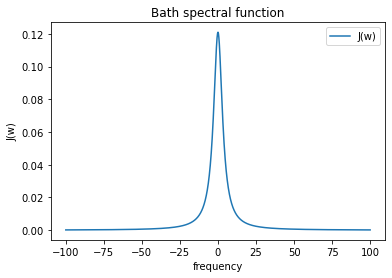

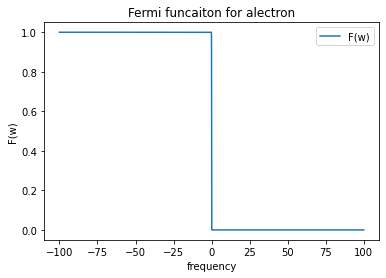

spectral_pole 
 (3.54+0j)
spectral_eta 
 (0.49434157872599604-0.2932442279950934j)


In [3]:
# the information of fermi funcaiton
T = 0.02                 #eV
chemical_potential = 0.0 #ev

fermi = np.zeros(omega_sample)
for i in range(omega_sample):
    if ((omega[i] - chemical_potential) / (T)) <= 50 :
        fermi[i] = 1.0 / ( 1.0 + np.exp( (omega[i] - chemical_potential) / (T) ) )
    elif ((omega[i] - chemical_potential) / (T)) > 50 :
        fermi[i] = 1.0 / 10e+22

# the information of bath spectral funcation
# the Lorentz type J(w) = 0.5 * sys_bath_coupling * band_width**2 / ( (w - band_center)**2 + band_width**2)
sys_bath_coupling = 0.242  #eV, is equal to HEOM-QUICK
band_width = 3.54         #eV
band_center = 0.0        #eV
bath_spectral = np.zeros(omega_sample, dtype=complex)
bath_spectral = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)
spectral_diss_rate = (band_width - 1.j * band_center) / hbar
spectral_eta = 0.5 * sys_bath_coupling * band_width \
                / ( 1.0 + np.exp((1.j * spectral_diss_rate - chemical_potential) * hbar / T )) / hbar**2

plt.title("Bath spectral function") 
plt.xlabel("frequency") 
plt.ylabel("J(w)") 
plt.plot(omega, bath_spectral.real, label = 'J(w)')
plt.legend(loc=1)
plt.show()

plt.title("Fermi funcaiton for alectron") 
plt.xlabel("frequency") 
plt.ylabel("F(w)") 
plt.plot(omega, fermi.real, label = 'F(w)')
plt.legend(loc=1)
plt.show()

print('spectral_pole \n', spectral_diss_rate * hbar)
print('spectral_eta \n', spectral_eta)


#the Matsubara scheme
#num_mats = 1001
#mats = np.linspace(-(num_mats - 1)/2, (num_mats - 1)/2, num_mats, dtype = np.complex128)
#fermi_mats = np.zeros(omega_sample, dtype = np.complex128)
#bath_corr_msd = np.zeros(time_sample, dtype=np.complex128)

# for i in range(num_mats):
#     mats[i] = (mats[i] * 2 + 1) * np.pi * complex(0,1.0)

# for i in range(omega_sample):
#     fermi_mats[i] = 0.5
#     for j in range(num_mats):
#        fermi_mats[i] = fermi_mats[i] + 1.0 / (mats[j] - omega[i]/T)

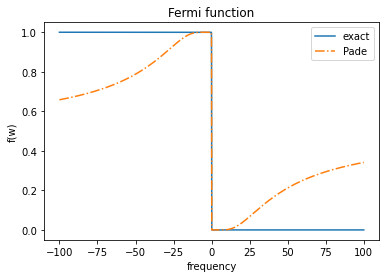

In [4]:
#the Pade scheme
num_pade = 20
b = np.zeros(2 * num_pade)
mat_xi = np.zeros((2 * num_pade, 2 * num_pade))
mat_varsigma = np.zeros((2 * num_pade - 1, 2 * num_pade - 1))
tilde_eta = np.zeros(num_pade, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole = np.zeros(num_pade, dtype = complex)              # namely cppole in evaluatepara.f90



for i in range(2 * num_pade):
    b[i] = 2 * (i) + 1

for i in range(2 * num_pade):
    for j in range(2 * num_pade):
        if (i == j-1 or i == j+1) :
            mat_xi[i,j] = 1.0 / np.sqrt(b[i] * b[j])

eigval_xi, eigvec_xi = np.linalg.eig(mat_xi) 
eigval_xi = np.sort(eigval_xi)
            
for i in range(2 * num_pade -1):
    for j in range(2 * num_pade -1):
        if (i == j-1 or i == j+1) :
            mat_varsigma[i,j] = 1.0 / np.sqrt(b[i+1] * b[j+1])

eigval_varsigma, eigvec_varsigma = np.linalg.eig(mat_varsigma)
eigval_varsigma = np.sort(eigval_varsigma)


for i in range(num_pade):
    pole[i] = (0. +2.j) / abs(eigval_xi[i])
    eigval_xi[i] = 4.0 / eigval_xi[i]**2
for i in range(num_pade-1):
    eigval_varsigma[i] = 4.0 / eigval_varsigma[i]**2

for i in range(num_pade):
    tilde_eta[i] = 0.5 * num_pade * (2 * num_pade + 1)
    for j in range(i):
        tilde_eta[i] = tilde_eta[i] * (eigval_varsigma[j] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
    for j in range(i+1,num_pade):
        tilde_eta[i] = tilde_eta[i] * (eigval_varsigma[j-1] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
    tilde_eta[i] = (-1. +0.j) * tilde_eta[i]

fermi_pade = np.zeros(omega_sample, dtype = np.complex128)
for i in range(omega_sample):
    fermi_pade[i] = 0.5
    for j in range(num_pade):
        fermi_pade[i] = fermi_pade[i] + tilde_eta[j] / (omega[i] / T + pole[j]) \
                                      + tilde_eta[j] / (omega[i] / T - pole[j])

        
plt.title("Fermi function") 
plt.xlabel("frequency") 
plt.ylabel("f(w)") 
plt.plot(omega, fermi, label = 'exact')
#plt.plot(omega, fermi_mats.real, label = 'Matsubara', linestyle = '--')
plt.plot(omega, fermi_pade.real, label = 'Pade', linestyle = '-.')
plt.legend(loc=1)
plt.show()

In [5]:
# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade = np.zeros(num_pade + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade = np.zeros(num_pade + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

spectral_diss_rate_pade = (band_width - 1.j * band_center) / hbar
spectral_eta_pade = 0.5 * sys_bath_coupling * band_width \
                   * fermi_by_pade((1.j * spectral_diss_rate - chemical_potential) * hbar) / hbar**2

print(0.5 * sys_bath_coupling * band_width)

diss_rate_pade[0] = spectral_diss_rate_pade
eta_pade[0] = spectral_eta_pade

for i in range(1, num_pade + 1):
    diss_rate_pade[i] = -1.j * T * pole[i - 1] / hbar
    eta_pade[i] = 2.j * tilde_eta[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2

print('pade_diss_rate \n', -1 * diss_rate_pade * hbar)
print('pade_eta \n', eta_pade)
print('pade_eta * hbar**2 \n', eta_pade * hbar**2)

0.42834
pade_diss_rate 
 [ -3.54      +0.j  -0.06283185+0.j  -0.18849556+0.j  -0.31415927+0.j
  -0.43982297+0.j  -0.56548668+0.j  -0.69115038+0.j  -0.81681409+0.j
  -0.9424778 +0.j  -1.0681415 +0.j  -1.19380535+0.j  -1.31949279+0.j
  -1.44619637+0.j  -1.58443278+0.j  -1.76495399+0.j  -2.02608389+0.j
  -2.42072165+0.j  -3.05905273+0.j  -4.22944946+0.j  -6.99190012+0.j
 -20.89157037+0.j]
pade_eta 
 [0.49434158+0.00634921j 0.        -0.01117508j 0.        -0.01120333j
 0.        -0.01126024j 0.        -0.01134671j 0.        -0.0114641j
 0.        -0.01161428j 0.        -0.01179978j 0.        -0.01202383j
 0.        -0.01229054j 0.        -0.01260517j 0.        -0.01298506j
 0.        -0.01376699j 0.        -0.01701663j 0.        -0.02533947j
 0.        -0.04181052j 0.        -0.08180106j 0.        -0.29090003j
 0.        +0.34281601j 0.        +0.14154265j 0.        +0.10969498j]
pade_eta * hbar**2 
 [0.21417+0.00275075j 0.     -0.00484153j 0.     -0.00485376j
 0.     -0.00487842j 0.     

In [ ]:
# compare the pade results and the exact correlation function in time domain
# exact results

for i in range(time_sample_for_corr):
    #bath_corr_exact[i] = gauss_Legendre_integral(fdt, down_limit = -20, upper_limit = 20, interval = 100, t=tt_for_corr[i])
    bath_corr_exact_real[i],err = integrate.quad(fdt_real, a = -100, b = 100, args=(tt_for_corr[i]), limit = 20000)
    bath_corr_exact_imag[i],err = integrate.quad(fdt_imag, a = -200, b = 200, args=(tt_for_corr[i]), limit = 10000)
    bath_corr_exact[i] = complex(bath_corr_exact_real[i], bath_corr_exact_imag[i])
    #print(bath_corr_exact[i])

print('Done!')

In [6]:
# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade + 1):
        bath_corr_psd[i] = bath_corr_psd[i] + eta_pade[j] * hbar**2 * np.exp(-1 * diss_rate_pade[j] * hbar * tt_for_corr[i])
        if i == 99:
            print("bath_corr_psd[i]",tt_for_corr[i], bath_corr_psd[i].imag)

print('Done!')

print('pade_diss_rate \n', -1 * diss_rate_pade * hbar)
print('pade_eta \n', eta_pade * hbar**2)

bath_corr_psd[i] 0.99 8.268421393612534e-05
bath_corr_psd[i] 0.99 -0.004466856413044276
bath_corr_psd[i] 0.99 -0.008494346692827627
bath_corr_psd[i] 0.99 -0.012068770532036466
bath_corr_psd[i] 0.99 -0.015249297443896869
bath_corr_psd[i] 0.99 -0.01808682085816968
bath_corr_psd[i] 0.99 -0.02062523646936418
bath_corr_psd[i] 0.99 -0.022902509444776613
bath_corr_psd[i] 0.99 -0.024951569527443426
bath_corr_psd[i] 0.99 -0.026801065535835375
bath_corr_psd[i] 0.99 -0.028476015776424113
bath_corr_psd[i] 0.99 -0.029999568483899675
bath_corr_psd[i] 0.99 -0.03142444170497328
bath_corr_psd[i] 0.99 -0.032960387000492745
bath_corr_psd[i] 0.99 -0.03487325233887371
bath_corr_psd[i] 0.99 -0.03731049755937258
bath_corr_psd[i] 0.99 -0.04053674330311898
bath_corr_psd[i] 0.99 -0.04663535294082285
bath_corr_psd[i] 0.99 -0.044379377857729066
bath_corr_psd[i] 0.99 -0.044318921690169204
bath_corr_psd[i] 0.99 -0.04431892164067487
Done!
pade_diss_rate 
 [ -3.54      +0.j  -0.06283185+0.j  -0.18849556+0.j  -0.31415

In [7]:
# prony results
dimension_Hankel = 1500
num_prony = 10

tt_for_prony_min = 0.0
tt_for_prony_max = 80.0
time_sample_for_prony =  2 * dimension_Hankel + 1
tt_for_prony = np.linspace(tt_for_prony_min, tt_for_prony_max, time_sample_for_prony)
hankel_matrix_real = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
hankel_matrix_imag = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
phi_real = np.zeros(time_sample_for_prony)
phi_imag = np.zeros(time_sample_for_prony)

for j in range(time_sample_for_prony):
    for k in  range(num_pade + 1):
        phi_real[j] = phi_real[j] + np.real(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j]))
        phi_imag[j] = phi_imag[j] + np.imag(eta_pade[k] * hbar**2 * np.exp(-1 * diss_rate_pade[k] * hbar * tt_for_prony[j]))

print('pade_diss_rate \n', -1 * diss_rate_pade * hbar)
print('pade_eta \n', eta_pade * hbar**2)
        
for n in range(dimension_Hankel + 1):
    for m in range(dimension_Hankel + 1):
        hankel_matrix_real[n,m] = phi_real[n + m]
        hankel_matrix_imag[n,m] = phi_imag[n + m]
        
print('Done!')

pade_diss_rate 
 [ -3.54      +0.j  -0.06283185+0.j  -0.18849556+0.j  -0.31415927+0.j
  -0.43982297+0.j  -0.56548668+0.j  -0.69115038+0.j  -0.81681409+0.j
  -0.9424778 +0.j  -1.0681415 +0.j  -1.19380535+0.j  -1.31949279+0.j
  -1.44619637+0.j  -1.58443278+0.j  -1.76495399+0.j  -2.02608389+0.j
  -2.42072165+0.j  -3.05905273+0.j  -4.22944946+0.j  -6.99190012+0.j
 -20.89157037+0.j]
pade_eta 
 [0.21417+0.00275075j 0.     -0.00484153j 0.     -0.00485376j
 0.     -0.00487842j 0.     -0.00491588j 0.     -0.00496674j
 0.     -0.00503181j 0.     -0.00511217j 0.     -0.00520924j
 0.     -0.00532479j 0.     -0.0054611j  0.     -0.00562569j
 0.     -0.00596445j 0.     -0.00737233j 0.     -0.01097815j
 0.     -0.01811411j 0.     -0.03543973j 0.     -0.12603038j
 0.     +0.14852262j 0.     +0.06132235j 0.     +0.04752458j]
Done!


In [8]:
sigma_real, U_real = takagi_chen(hankel_matrix_real)
sigma_imag, U_imag = takagi_chen(hankel_matrix_imag)

print(
    "error of decompose real part\n",
    np.sum(np.abs(hankel_matrix_real - np.dot(np.dot(U_real, np.diag(sigma_real)), U_real.T))), "\n"
    "error of decompose imag part\n",
    np.sum(np.abs(hankel_matrix_imag - np.dot(np.dot(U_imag, np.diag(sigma_imag)), U_imag.T))))

print('Done!')

print(sigma_imag[0])

error of decompose real part
 9.726304766867893e-15 
error of decompose imag part
 1.838445028022094e-12
Done!
3.027841048039191


In [9]:
prony_roots_real = np.roots(U_real[:, num_prony][::-1])
tmp_index = prony_roots_real != 0
prony_roots_real = prony_roots_real[tmp_index]
prony_roots_real_new = prony_roots_real[np.argsort(np.abs(prony_roots_real))[:num_prony]]


prony_roots_imag = np.roots(U_imag[:, num_prony][::-1])
tmp_index = prony_roots_imag != 0
prony_roots_real = prony_roots_imag[tmp_index]
prony_roots_imag_new = prony_roots_imag[np.argsort(np.abs(prony_roots_imag))[:num_prony]]

print('Done!')

Done!


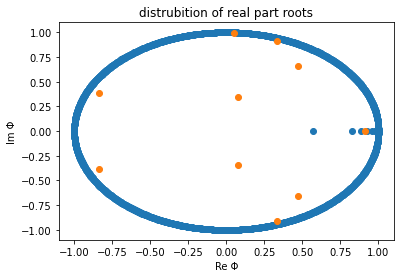

[ 0.07456851-3.42968184e-01j  0.07456851+3.42968184e-01j
  0.46955061-6.60980256e-01j  0.46955061+6.60980256e-01j
  0.90991872+8.58571776e-16j -0.84035011+3.83392044e-01j
 -0.84035011-3.83392044e-01j  0.33249618+9.08585264e-01j
  0.33249618-9.08585264e-01j  0.04841777+9.92163276e-01j]


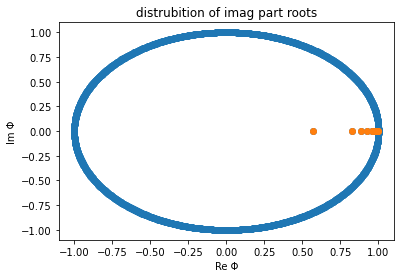

[0.57279885+0.00000000e+00j 0.82841938-3.10579185e-16j
 0.88937667+2.33917044e-15j 0.92888028-2.65954624e-15j
 0.95778051-3.08147883e-15j 0.97533407+8.61812416e-15j
 0.98547647-4.40858053e-15j 0.99124189-4.45105098e-15j
 0.9949734 +9.27289379e-15j 0.99832586-7.77156117e-16j]


In [10]:
plt.title("distrubition of real part roots") 
plt.xlabel("Re Φ") 
plt.ylabel("Im Φ")
plt.scatter(prony_roots_real.real, prony_roots_real.imag)
plt.scatter(prony_roots_real_new.real, prony_roots_real_new.imag)
plt.show()

print(prony_roots_real_new)

plt.title("distrubition of imag part roots") 
plt.xlabel("Re Φ") 
plt.ylabel("Im Φ")
plt.scatter(prony_roots_imag.real, prony_roots_imag.imag)
plt.scatter(prony_roots_imag_new.real, prony_roots_imag_new.imag)
plt.show()
print(prony_roots_imag_new)

In [11]:
omega_matrix_real = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_real[i, j] = prony_roots_real_new[j]**i
eta_prony_real_tmp = np.dot(linalg.inv(np.dot(omega_matrix_real.T, omega_matrix_real)), np.dot(omega_matrix_real.T, phi_real))
print(eta_prony_real_tmp)


omega_matrix_imag = np.zeros((time_sample_for_prony, num_prony), dtype=complex)
for i in range(time_sample_for_prony):
    for j in range(num_prony):
        omega_matrix_imag[i, j] = prony_roots_imag_new[j]**i
eta_prony_imag_tmp = np.dot(linalg.inv(np.dot(omega_matrix_imag.T, omega_matrix_imag)), np.dot(omega_matrix_imag.T, phi_imag))
print(eta_prony_imag_tmp)

print('Done!')

[-6.80011603e-15+3.55271368e-15j  2.41057174e-14+1.42108547e-14j
 -1.11022302e-15-8.25728375e-16j -9.18709553e-15-5.82867088e-15j
  2.14170000e-01-2.61596300e-15j -5.72458747e-16-2.56739074e-16j
 -2.15105711e-16+5.55111512e-17j -4.78783679e-16-1.95676808e-15j
 -6.24500451e-17+3.81639165e-17j  1.27675648e-15-6.66133815e-15j]
[ 0.04749412+3.06069588e-15j  0.05781445-3.45025933e-14j
  0.12769238+1.14043224e-13j -0.14134023-1.52953538e-13j
 -0.04305055+1.50367518e-13j -0.02107749-1.74037121e-13j
 -0.01132375+1.83064720e-13j -0.0064271 -1.38662807e-13j
 -0.00494   +5.40368283e-14j -0.0048418 -4.30165218e-15j]
Done!


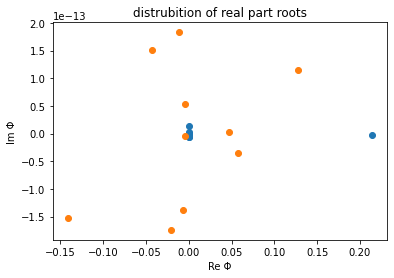

In [12]:
plt.title("distrubition of real part roots") 
plt.xlabel("Re Φ") 
plt.ylabel("Im Φ")
plt.scatter(np.real(eta_prony_real_tmp),np.imag(eta_prony_real_tmp), label = 'real')
plt.scatter(np.real(eta_prony_imag_tmp),np.imag(eta_prony_imag_tmp), label = 'imag')
plt.show()

In [13]:
bath_corr_prony_real = np.zeros(time_sample_for_corr, dtype=complex)
bath_corr_prony_imag = np.zeros(time_sample_for_corr, dtype=complex)


diss_rate_prony_real_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_real_new ) ) + 1.j * np.angle(prony_roots_real_new) )
diss_rate_prony_imag_tmp =  -2 * dimension_Hankel \
                            / tt_for_prony_max * ( np.log( np.abs( prony_roots_imag_new ) ) + 1.j * np.angle(prony_roots_imag_new) )

eta_prony_real = np.zeros(num_prony + 1, dtype = complex)
diss_rate_prony_real = np.zeros(num_prony + 1, dtype = complex)
eta_prony_imag = np.zeros(num_prony + 1, dtype = complex)
diss_rate_prony_imag = np.zeros(num_prony + 1, dtype = complex)

spectrum_pole_prony = (1 + 0.j) * (band_width - 1.j * band_center)
spectrum_eta_prony = 0.5 * (0.5 * sys_bath_coupling) * band_width

print("spectrum_pole_prony\n",spectrum_pole_prony)
print("spectrum_eta_prony\n",spectrum_eta_prony)


eta_prony_real[num_prony] = spectrum_eta_prony
diss_rate_prony_real[num_prony] = spectrum_pole_prony
eta_prony_real[0:num_prony] = eta_prony_real_tmp * 1.j
diss_rate_prony_real[0:num_prony] = diss_rate_prony_real_tmp

eta_prony_imag[num_prony] = spectrum_eta_prony
diss_rate_prony_imag[num_prony] = spectrum_pole_prony
eta_prony_imag[0:num_prony] = eta_prony_imag_tmp * 1.j
diss_rate_prony_imag[0:num_prony] = diss_rate_prony_imag_tmp

for i in range(time_sample_for_corr):
    for j in range(num_prony + 1):
        bath_corr_prony_real[i] = bath_corr_prony_real[i] + eta_prony_real[j] * np.exp(-1 * diss_rate_prony_real[j] * tt_for_corr[i])
        bath_corr_prony_imag[i] = bath_corr_prony_imag[i] + eta_prony_imag[j] * np.exp(-1 * diss_rate_prony_imag[j] * tt_for_corr[i])
        if i == 99:
            print("bath_corr_prony_imag[i]",tt_for_corr[i], bath_corr_prony_imag[i].imag)

print('Done!')

print("diss_rate\n",diss_rate_prony_imag)
print("eta\n",eta_prony_imag)

1.5163236
spectrum_pole_prony
 (3.54+0j)
spectrum_eta_prony
 0.21417
bath_corr_prony_imag[i] 0.99 4.925714652682479e-11
bath_corr_prony_imag[i] 0.99 5.3342999628807734e-05
bath_corr_prony_imag[i] 0.99 0.0016976120432617972
bath_corr_prony_imag[i] 0.99 -0.007438705840544493
bath_corr_prony_imag[i] 0.99 -0.01611788818061517
bath_corr_prony_imag[i] 0.99 -0.024457362522050313
bath_corr_prony_imag[i] 0.99 -0.03103557162823983
bath_corr_prony_imag[i] 0.99 -0.03567201243554847
bath_corr_prony_imag[i] 0.99 -0.039769122970297235
bath_corr_prony_imag[i] 0.99 -0.04431891381074292
bath_corr_prony_imag[i] 0.99 -0.04431891381074292
Done!
diss_rate
 [20.89577511-0.00000000e+00j  7.05884063+1.40589654e-14j
  4.39629107-9.86296291e-14j  2.76657828+1.07369040e-13j
  1.61762382+1.20649203e-13j  0.93657114-3.31352780e-13j
  0.54862605+1.67758211e-13j  0.32987585+1.68389183e-13j
  0.18897287-3.49490265e-13j  0.06283269+2.91922261e-14j
  3.54      +0.00000000e+00j]
eta
 [-3.06069588e-15+0.04749412j  3.45025

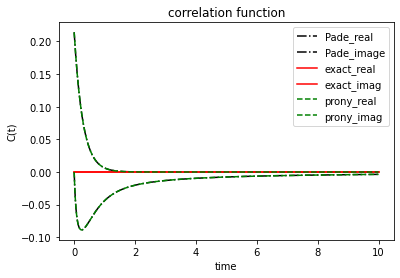

In [14]:
plt.title("correlation function") 
plt.xlabel("time") 
plt.ylabel("C(t)") 
plt.plot(tt_for_corr, bath_corr_psd.real, label = 'Pade_real', linestyle = '-.', color = 'k') 
plt.plot(tt_for_corr, bath_corr_psd.imag, label = 'Pade_image', linestyle = '-.', color = 'k') 
plt.plot(tt_for_corr, bath_corr_exact_real, label = 'exact_real', color = 'r') 
plt.plot(tt_for_corr, bath_corr_exact_imag, label = 'exact_imag', color = 'r') 
plt.plot(tt_for_corr, bath_corr_prony_real.real, label = 'prony_real', linestyle = '--', color = 'g')
plt.plot(tt_for_corr, bath_corr_prony_imag.imag, label = 'prony_imag', linestyle = '--', color = 'g')
plt.legend(loc=1)
plt.show()

In [15]:
omega_max_freq = 100.0
omega_min_freq = -100.0
omega_sample_freq = 2000 + 1
omega_freq = np.linspace(omega_min_freq, omega_max_freq, omega_sample_freq)


bath_corr_psd_freq = np.zeros(omega_sample_freq, dtype = complex)
bath_corr_exact_freq = np.zeros(omega_sample_freq, dtype = complex)
bath_corr_prony_imag_freq = np.zeros(omega_sample_freq, dtype = complex)
bath_corr_prony_real_freq = np.zeros(omega_sample_freq, dtype = complex)


for i in range(omega_sample_freq):
    #bath_corr_psd_freq[i] =   Jfermi_psd(omega_freq[i])
    bath_corr_psd_freq[i] = J_fit(omega_freq[i], diss_rate_pade * hbar, eta_pade * hbar**2)
    bath_corr_exact_freq[i] = Jfermi_exact(omega_freq[i])
    bath_corr_prony_imag_freq[i] = J_fit(omega_freq[i], diss_rate_prony_imag, eta_prony_imag)
    #bath_corr_prony_imag_freq[i] += spectrum_eta_prony / ( spectrum_pole_prony * hbar + 1.j * omega_freq[i] )
    #bath_corr_prony_real_freq[i] = J_fit(omega_freq[i], diss_rate_prony_real, eta_prony_real)

i 0
fun (0.0605+0.0007770478824024035j) eta (0.21417+0.0027507495037045085j) rate (3.54+0j) omega 0.0
(expn[i] + sigma * 1.j * w)[0] (3.54+0j)
i 1
fun (0.0605-0.07627821936754903j) eta -0.004841525230256916j rate (0.06283185307179592+0j) omega 0.0
(expn[i] + sigma * 1.j * w)[0] (0.06283185307179592+0j)
i 2
fun (0.0605-0.10202822529078591j) eta -0.004853761766300083j rate (0.18849555921538777+0j) omega 0.0
(expn[i] + sigma * 1.j * w)[0] (0.18849555921538777+0j)
i 3
fun (0.0605-0.1175567227115766j) eta -0.004878421341844398j rate (0.3141592653589786+0j) omega 0.0
(expn[i] + sigma * 1.j * w)[0] (0.3141592653589786+0j)
i 4
fun (0.0605-0.1287336835421526j) eta -0.004915884124871756j rate (0.43982297150256977+0j) omega 0.0
(expn[i] + sigma * 1.j * w)[0] (0.43982297150256977+0j)
i 5
fun (0.0605-0.13751680608936806j) eta -0.004966738788583978j rate (0.5654866776461621+0j) omega 0.0
(expn[i] + sigma * 1.j * w)[0] (0.5654866776461621+0j)
i 6
fun (0.0605-0.14479714080092393j) eta -0.0050318061300

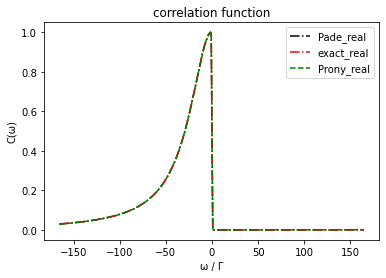

In [16]:
plt.title("correlation function") 
plt.xlabel("ω / Γ") 
plt.ylabel("C(ω)")
plt.plot(omega_freq[800:1200]/(sys_bath_coupling/2), bath_corr_psd_freq[800:1200].real/max(np.abs(bath_corr_psd_freq.real)) , label = 'Pade_real', linestyle = '-.', color = 'k')
plt.plot(omega_freq[800:1200]/(sys_bath_coupling/2), bath_corr_exact_freq[800:1200].real/max(np.abs(bath_corr_exact_freq.real)) , label = 'exact_real', linestyle = '-.', color = 'r')
plt.plot(omega_freq[800:1200]/(sys_bath_coupling/2), bath_corr_prony_imag_freq[800:1200].real/max(np.abs(bath_corr_prony_imag_freq.real)), label = 'Prony_real', linestyle = '--', color = 'g')

#plt.plot(fourier_psd/(sys_bath_coupling/2), bath_corr_psd_freq_fourier.real/max(bath_corr_psd_freq_fourier.real) , label = 'Pade_real_Fourier')
#plt.plot(fourier_exact/(sys_bath_coupling/2), bath_corr_exact_freq_fourier.real/max(bath_corr_exact_freq_fourier.real) , label = 'exact_real_Fourier', linestyle = '--')
plt.legend(loc=1)
plt.show()